In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
from IPython.display import display
from sklearn.externals import joblib

basepath = os.path.expanduser('../')

In [3]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

## Load Data

In [4]:
%%time

app_train   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_train.pkl'))
app_test    = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/application_test.pkl'))

# additional tables

bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau.pkl'))
bureau_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/bureau_balance.pkl'))
# prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/POS_CASH_balance.pkl'))
# credit_bal   = pd.read_pickle(os.path.join(basepath, 'data/interim/feature_groups/credit_card_balance.pkl'))

CPU times: user 134 ms, sys: 370 ms, total: 504 ms
Wall time: 503 ms


## Hypothesis

21st July, 2018

1. Go through multiple records of a client applying for loan by joining information from multiple sources.
1. Comment on how the training and test data were generated. ( Adversarial Validation )

22nd July, 2018

1. POS_CASH table

23rd July, 2018
1. Bureau data ( particularly look at CREDIT DAY OVERDUE )
    - Number of days past due on CB Credit at the time of application for related loan in our sample.

### July 21st, 2018

In [6]:
# random sample of defaulters
app_train.loc[app_train.TARGET == 1, :].sample(n=10).SK_ID_CURR

182163    311137
267585    410017
238808    376621
209300    342582
52926     161301
96266     211762
106089    223092
135196    256800
22132     125773
186085    315729
Name: SK_ID_CURR, dtype: int32

In [57]:
SK_ID_CURR = 125773

In [58]:
# current application
display_all(app_train.loc[app_train.SK_ID_CURR == SK_ID_CURR].T)

,22132
AMT_ANNUITY,34456.5
AMT_CREDIT,1.04256e+06
AMT_GOODS_PRICE,900000
AMT_INCOME_TOTAL,157500
AMT_REQ_CREDIT_BUREAU_DAY,0
AMT_REQ_CREDIT_BUREAU_HOUR,0
AMT_REQ_CREDIT_BUREAU_MON,0
AMT_REQ_CREDIT_BUREAU_QRT,1
AMT_REQ_CREDIT_BUREAU_WEEK,0
AMT_REQ_CREDIT_BUREAU_YEAR,2


** Observations **

- AMT_ANNUITY looks like monthly payment.
- AMT_INCOME_TOTAL is annual income.

```
AMT_ANNUITY	      51021
AMT_CREDIT	      473760
AMT_GOODS_PRICE	  450000
AMT_INCOME_TOTAL  135000
```

```
AMT_ANNUITY	     7501.5
AMT_CREDIT	     71955
AMT_GOODS_PRICE	 67500
AMT_INCOME_TOTAL 54000
```

```
AMT_ANNUITY	      21091.5
AMT_CREDIT	      717003
AMT_GOODS_PRICE	  598500
AMT_INCOME_TOTAL  94500
```

#### Let's look at difference 

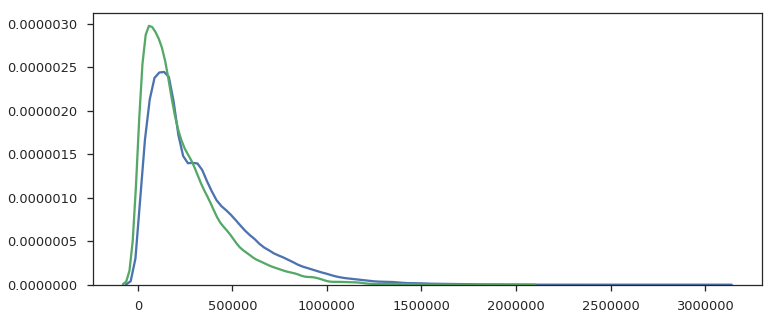

In [43]:
plt.figure(figsize=(12, 5))
mask = app_train.TARGET == 0

sns.kdeplot(app_train.loc[mask, 'AMT_CREDIT'] * app_train.loc[mask, 'EXT_SOURCE_2'])
sns.kdeplot(app_train.loc[~mask, 'AMT_CREDIT'] * app_train.loc[~mask, 'EXT_SOURCE_2']);

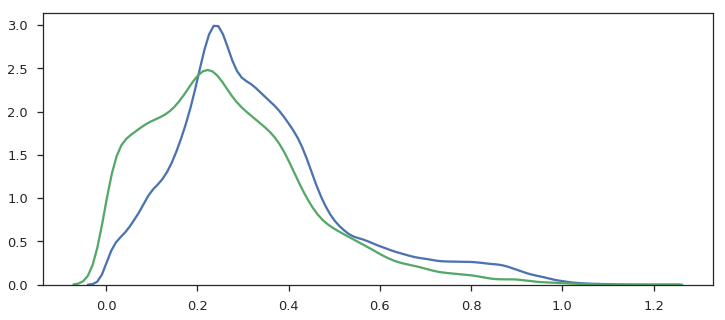

In [49]:
plt.figure(figsize=(12, 5))
mask = app_train.TARGET == 0

sns.kdeplot(((app_train.loc[mask, 'AMT_ANNUITY'] * 12)  / app_train.loc[mask, 'AMT_CREDIT']) * app_train.loc[mask, 'EXT_SOURCE_2'])
sns.kdeplot(((app_train.loc[~mask, 'AMT_ANNUITY'] * 12) / app_train.loc[~mask, 'AMT_CREDIT']) * app_train.loc[~mask, 'EXT_SOURCE_2']);

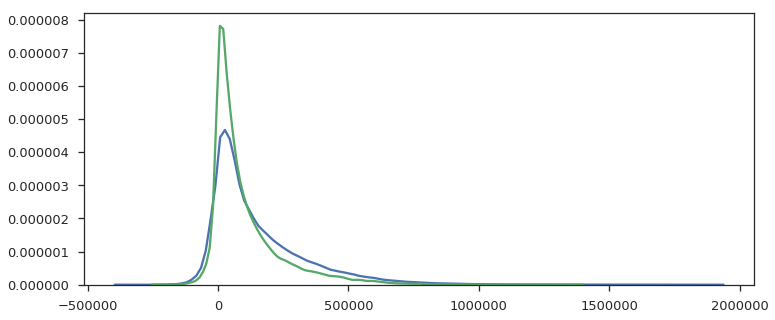

In [50]:
plt.figure(figsize=(12, 5))
mask = app_train.TARGET == 0

sns.kdeplot(((app_train.loc[mask, 'AMT_CREDIT'] - app_train.loc[mask, 'AMT_ANNUITY'] * 12)) * app_train.loc[mask, 'EXT_SOURCE_2'])
sns.kdeplot(((app_train.loc[~mask, 'AMT_CREDIT'] - app_train.loc[~mask, 'AMT_ANNUITY'] * 12)) * app_train.loc[~mask, 'EXT_SOURCE_2']);

In [61]:
ss = pd.crosstab(app_train.NAME_EDUCATION_TYPE.astype(np.str) + '_' +\
            app_train.NAME_FAMILY_STATUS.astype(np.str) + '_' +\
            app_train.NAME_HOUSING_TYPE.astype(np.str) + '_' +\
            app_train.NAME_INCOME_TYPE.astype(np.str),
            app_train.TARGET
           ).sort_values(by=0, ascending=False)
ss.loc[:, 'ratio'] = (ss[1] / (ss[0] + ss[1]))
ss

TARGET,0.0,1.0,ratio
row_0,,,
Secondary / secondary special_Married_House / apartment_Working,62695,6622,0.095532
Secondary / secondary special_Married_House / apartment_Pensioner,23817,1320,0.052512
Secondary / secondary special_Married_House / apartment_Commercial associate,23251,1964,0.077890
Higher education_Married_House / apartment_Working,19066,1121,0.055531
Higher education_Married_House / apartment_Commercial associate,13305,681,0.048692
Secondary / secondary special_Single / not married_House / apartment_Working,11315,1684,0.129548
Secondary / secondary special_Civil marriage_House / apartment_Working,9987,1361,0.119933
Secondary / secondary special_Widow_House / apartment_Pensioner,6952,426,0.057739
Secondary / secondary special_Married_House / apartment_State servant,6828,467,0.064016


In [62]:
ss = app_train.NAME_EDUCATION_TYPE.astype(np.str) + '_' +\
            app_train.NAME_FAMILY_STATUS.astype(np.str) + '_' +\
            app_train.NAME_HOUSING_TYPE.astype(np.str) + '_' +\
            app_train.NAME_INCOME_TYPE.astype(np.str)

In [66]:
zz = pd.Series(pd.factorize(ss)[0])

In [70]:
counts = zz.value_counts()
counts[counts < 8 ]

300    7
402    7
335    7
382    7
175    7
293    7
312    7
360    7
355    7
357    7
265    7
322    7
371    7
250    6
169    6
358    6
383    6
267    6
333    6
364    6
165    6
218    6
315    6
399    6
270    6
350    5
334    5
155    5
337    5
375    5
      ..
461    1
455    1
460    1
456    1
458    1
447    1
469    1
440    1
444    1
441    1
405    1
222    1
477    1
284    1
476    1
459    1
443    1
474    1
473    1
424    1
445    1
427    1
472    1
292    1
216    1
446    1
471    1
341    1
470    1
430    1
Length: 180, dtype: int64

### July 22nd, 2018

In [7]:
display_all(pos_cash.head().T)

,0,1,2,3,4
SK_ID_PREV,1803195,1715348,1784872,1903291,2341044
SK_ID_CURR,182943,367990,397406,269225,334279
MONTHS_BALANCE,-31,-33,-32,-35,-35
CNT_INSTALMENT,48,36,12,48,36
CNT_INSTALMENT_FUTURE,45,35,9,42,35
NAME_CONTRACT_STATUS,Active,Active,Active,Active,Active
SK_DPD,0,0,0,0,0
SK_DPD_DEF,0,0,0,0,0


In [5]:
# installments left to be paid
%time pos_cash_sorted = pos_cash.sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], ascending=[True, True, False])

CPU times: user 8.55 s, sys: 1.08 s, total: 9.63 s
Wall time: 9.65 s


In [12]:
most_recent_snapshot = pos_cash_sorted.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['MONTHS_BALANCE'].max()
most_recent_snapshot = most_recent_snapshot\
                       .merge(pos_cash_sorted, on=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], how='inner')

In [52]:
active_pos_cash_entries      = most_recent_snapshot.loc[most_recent_snapshot.NAME_CONTRACT_STATUS == 'Active']
active_pos_cash_entries.loc[:, 'ratio'] = active_pos_cash_entries.CNT_INSTALMENT_FUTURE / (-active_pos_cash_entries.MONTHS_BALANCE)
total_remaining_installments = active_pos_cash_entries.groupby('SK_ID_CURR')['ratio'].sum()

In [53]:
total_remaining_installments = app_train.SK_ID_CURR.map(total_remaining_installments)
print(total_remaining_installments[total_remaining_installments.isnull()].shape[0] / len(app_train))

0.49326040369287605


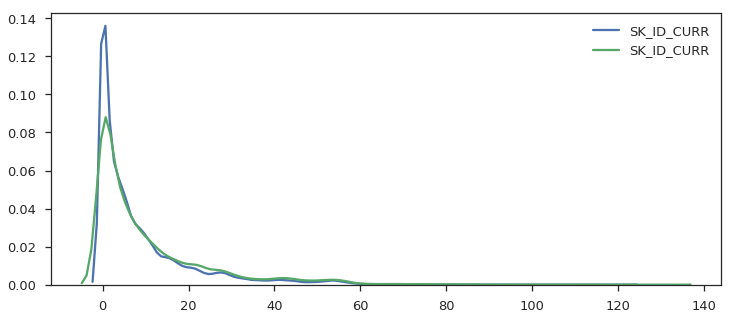

In [54]:
plt.figure(figsize=(12, 5))
sns.kdeplot(total_remaining_installments[app_train.TARGET == 0])
sns.kdeplot(total_remaining_installments[app_train.TARGET == 1]);

In [6]:
# days past due
most_recent_snapshot = pos_cash_sorted.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['MONTHS_BALANCE'].max()
most_recent_snapshot = most_recent_snapshot\
                       .merge(pos_cash_sorted, on=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], how='inner')

In [27]:
total_dpd = most_recent_snapshot.groupby(['SK_ID_CURR'])['SK_DPD'].min()
total_dpd = app_train.SK_ID_CURR.map(total_dpd)
total_dpd[total_dpd.isnull()].shape[0] / len(total_dpd)

0.05875236983392464

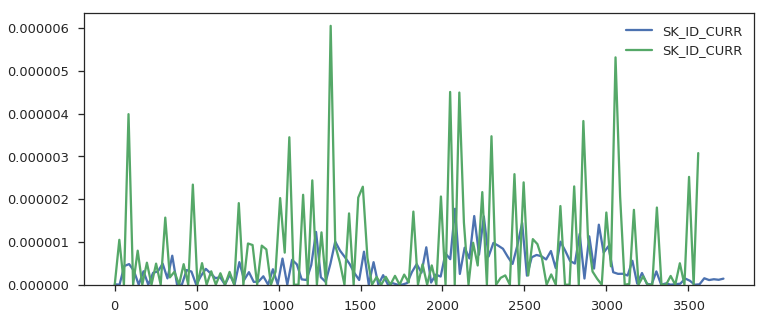

In [28]:
plt.figure(figsize=(12, 5))
sns.kdeplot(total_dpd[app_train.TARGET == 0])
sns.kdeplot(total_dpd[app_train.TARGET == 1]);

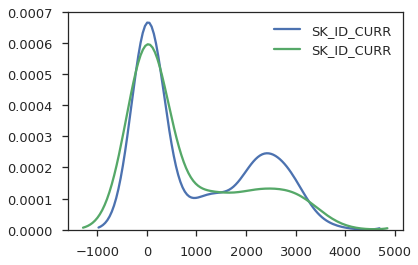

In [30]:
sns.kdeplot(total_dpd[(total_dpd > 0) & (app_train.TARGET == 0)])
sns.kdeplot(total_dpd[(total_dpd > 0) & (app_train.TARGET == 1)]);

In [33]:
# completed to total credits ratio
total_credits        = pos_cash_sorted.groupby('SK_ID_CURR').size()
most_recent_snapshot = pos_cash_sorted.groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)['MONTHS_BALANCE'].max()
most_recent_snapshot = most_recent_snapshot\
                       .merge(pos_cash_sorted, on=['SK_ID_CURR', 'SK_ID_PREV', 'MONTHS_BALANCE'], how='inner')

In [44]:
most_recent_snapshot.NAME_CONTRACT_STATUS.value_counts()

Completed                698421
Active                   236149
Signed                     1272
Returned to the store       304
Demand                      102
Approved                     58
Amortized debt               17
Canceled                      2
XNA                           0
Name: NAME_CONTRACT_STATUS, dtype: int64

In [45]:
most_recent_snapshot.NAME_CONTRACT_STATUS.cat.codes.value_counts()

4    698421
0    236149
7      1272
6       304
5       102
2        58
1        17
3         2
dtype: int64

In [37]:
most_recent_snapshot.loc[:, 'recent_status'] = (most_recent_snapshot.NAME_CONTRACT_STATUS == 'Completed').astype(np.uint8)
completed_credits    = most_recent_snapshot.groupby('SK_ID_CURR')['recent_status'].sum()

In [39]:
ratio_completed_to_total = (completed_credits / total_credits).fillna(0)
ratio_completed_to_total = app_train.SK_ID_CURR.map(ratio_completed_to_total)
ratio_completed_to_total[ratio_completed_to_total.isnull()].shape[0] / len(ratio_completed_to_total)

0.05875236983392464

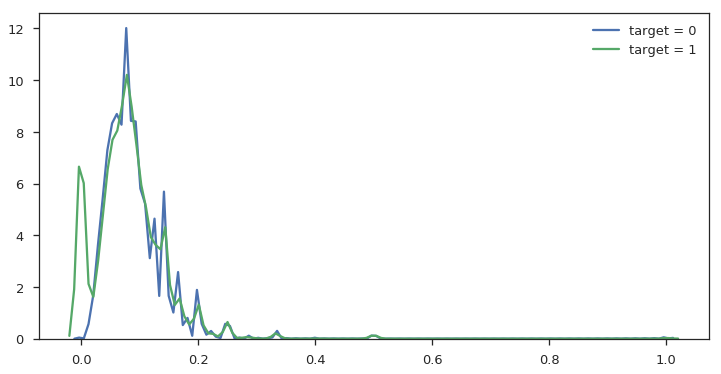

In [43]:
plt.figure(figsize=(12, 6))
sns.kdeplot(ratio_completed_to_total[app_train.TARGET == 0], label='target = 0')
sns.kdeplot(ratio_completed_to_total[app_train.TARGET == 1], label='target = 1');

### July 23rd, 2018

In [15]:
most_recent_bureau_update = bureau_bal.groupby('SK_ID_BUREAU', as_index=False)['MONTHS_BALANCE'].max()
most_recent_bureau_update = bureau.merge(most_recent_bureau_update, how='left')
most_recent_bureau_update = most_recent_bureau_update.groupby(['SK_ID_CURR'], as_index=False)['MONTHS_BALANCE'].max()

In [21]:
a = pd.DataFrame({'a': [1, 2, 3]}, index=[0, 2, 3])
a

,a
0,1
2,2
3,3


In [23]:
a.loc[a.index.isin([2, 3])]

,a
2,2
3,3


In [17]:
tr = app_train.loc[:, ['SK_ID_CURR']].merge(most_recent_bureau_update.loc[:, ['SK_ID_CURR', 'MONTHS_BALANCE']], how='left')
te = app_test.loc[:, ['SK_ID_CURR']].merge(most_recent_bureau_update.loc[:, ['SK_ID_CURR', 'MONTHS_BALANCE']], how='left')

In [18]:
tr.MONTHS_BALANCE.fillna(-9999).value_counts()

-9999.0    215280
 0.0        87829
-1.0          468
-2.0          214
-4.0          198
-3.0          189
-6.0          181
-8.0          172
-5.0          167
-7.0          150
-10.0         132
-9.0          128
-12.0         116
-13.0         115
-11.0         111
-14.0          91
-15.0          88
-19.0          83
-16.0          81
-18.0          80
-17.0          79
-22.0          73
-21.0          65
-24.0          58
-23.0          58
-25.0          57
-20.0          52
-26.0          49
-28.0          49
-29.0          48
            ...  
-70.0          14
-44.0          12
-82.0          12
-63.0          12
-60.0          12
-52.0          12
-53.0          12
-68.0          11
-61.0          11
-76.0          11
-55.0          11
-54.0          11
-81.0          10
-75.0          10
-79.0           9
-74.0           9
-59.0           9
-78.0           9
-72.0           8
-83.0           8
-80.0           7
-77.0           7
-73.0           7
-87.0           4
-84.0     

In [19]:
te.MONTHS_BALANCE.fillna(-9999).value_counts()

 0.0       42000
-9999.0     6433
-1.0         310
-2.0           1
Name: MONTHS_BALANCE, dtype: int64